In [1]:
import torch
import torchaudio
from torchaudio import transforms as T
import os
import matplotlib.pyplot as plt

In [2]:
# Plots waveform, stft, and mel (assuming stereo — only the first channel is plotted)
def plot_waveform(waveform):
    """Plots the waveform of the audio."""
    plt.figure(figsize=(10, 3))
    plt.title('Waveform')
    plt.plot(waveform[0].t().numpy())
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

def plot_stft(stft_result, sample_rate, hop_length):
    num_frames = stft_result.shape[-1]
    magnitude = stft_result.abs()
    time = torch.arange(0, num_frames) * hop_length / sample_rate  # Convert frames to time
    plt.figure(figsize=(10, 4))
    plt.imshow(magnitude[0].log2().detach().numpy(), aspect='auto', origin='lower', cmap='inferno', extent=[time[0], time[-1], 0, magnitude[0].shape[0]])
    plt.title('STFT Magnitude')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [bins]')
    plt.show()

def plot_mel_spectrogram(mel_result, sample_rate, hop_length):
    num_frames = mel_result.shape[-1]
    time = torch.arange(0, num_frames) * hop_length / sample_rate  # Convert frames to time
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_result[0].log2().detach().numpy(), aspect='auto', origin='lower', cmap='inferno', extent=[time[0], time[-1], 0, mel_result[0].shape[0]])
    plt.title('Mel Spectrogram')
    plt.xlabel('Time [s]')
    plt.ylabel('Mel bins')
    plt.show()

In [3]:
waveform, sample_rate = torchaudio.load("test.mp3", normalize=True)

In [4]:
class SpecAugmentPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        n_fft=1024,
        n_mel=256,
        stretch_factor=0.8,
        win_length=None,
        hop_length=160,
        power=None
     ):
        super().__init__()
        self.win_length, self.hop_length = win_length, hop_length
        self.power = power
        self.n_fft, self.n_mel, self.stretch_factor = n_fft, n_mel, stretch_factor
        self.input_freq = input_freq

        self.spec = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power)

        # Spec Augment
        self.time_stretch = T.TimeStretch(n_freq=n_fft //2 + 1, fixed_rate=stretch_factor, hop_length=hop_length)
        self.spec_mask = torch.nn.Sequential(
            T.FrequencyMasking(freq_mask_param=80),
            T.TimeMasking(time_mask_param=80),
        )

        self.mel_scale = T.MelScale(n_mels=n_mel, sample_rate=input_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Convert to complex-valued spectrogram
        spec = self.spec(waveform)

        # "Time warping": Modern methods sometimes skip this step
        # For full on time warping, this would include doing it to random sub segments
        spec = self.time_stretch(spec)

        # Convert to power-spectrogram
        if self.power is None:
          power_spec = spec.abs().pow(2)

        # Frequency and time masking
        # For full on masking, this would include more random masks
        power_spec = self.spec_mask(power_spec)

        # Convert to mel-scale
        mel = self.mel_scale(power_spec)

        return mel

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


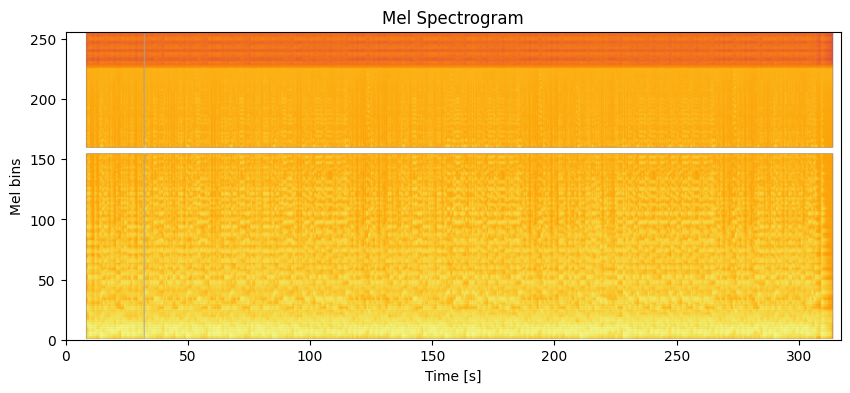

In [6]:
spec_aug = SpecAugmentPipeline()
aug = spec_aug(waveform)
plot_mel_spectrogram(aug, sample_rate, 160)

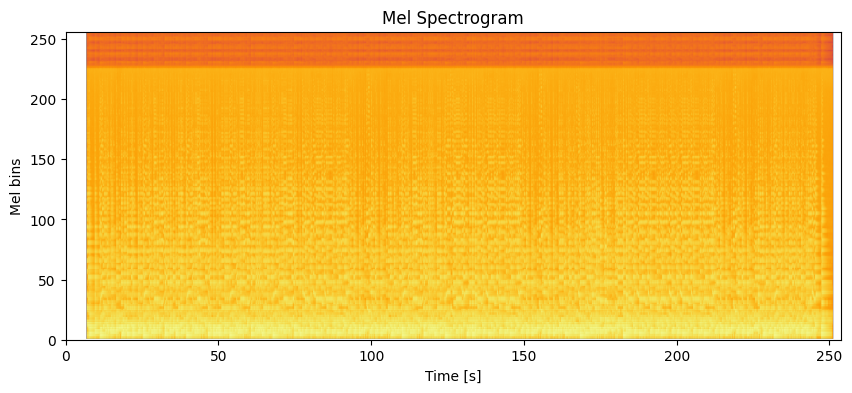

In [8]:
# original
plot_mel_spectrogram(spec_aug.mel_scale(spec_aug.spec(waveform).abs().pow(2)), sample_rate, 160)